# 1 Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import os
import pickle
import multiprocessing
from tabulate import tabulate
from itertools import product
import os
from scipy.stats import mode
# Uncomment this line if you run this code first time
#multiprocessing.set_start_method("fork")

## 1.1 What does your theory say about your data?

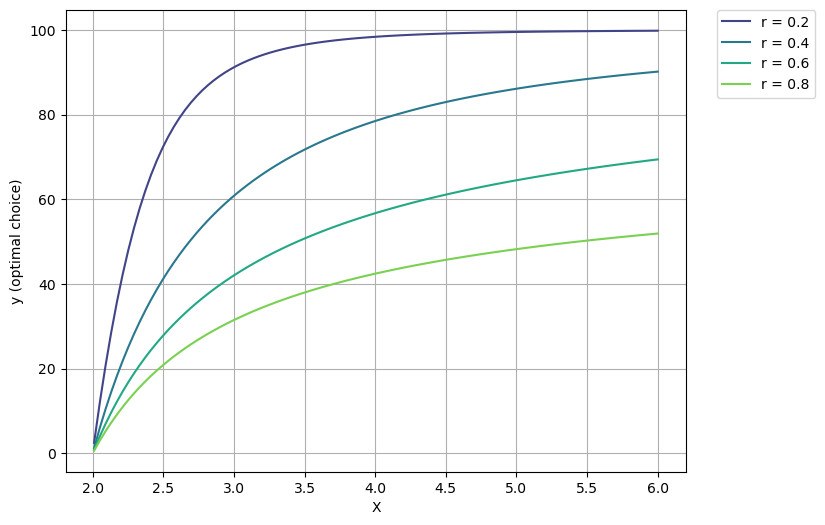

In [2]:
X = np.linspace(2.01, 6, num = 100)
r = np.array([0.2,0.4,0.6,0.8])
X_grid, r_grid = np.meshgrid(X, r)

dplt = pd.DataFrame({
    'X': X_grid.ravel(),
    'r': r_grid.ravel(),
})

dplt['y'] = 100 * (1 - (dplt['X'] - 1) ** (-1/dplt['r']))  \
    / ((dplt['X'] - 1) ** (1 - 1/dplt['r']) + 1)
dplt['r'] = 'r = ' + dplt['r'].astype(str)

plt.figure(figsize=(8, 6))
sns.lineplot(data=dplt, x='X', y='y', hue='r', palette='viridis')
plt.xlabel('X')
plt.ylabel('y (optimal choice)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

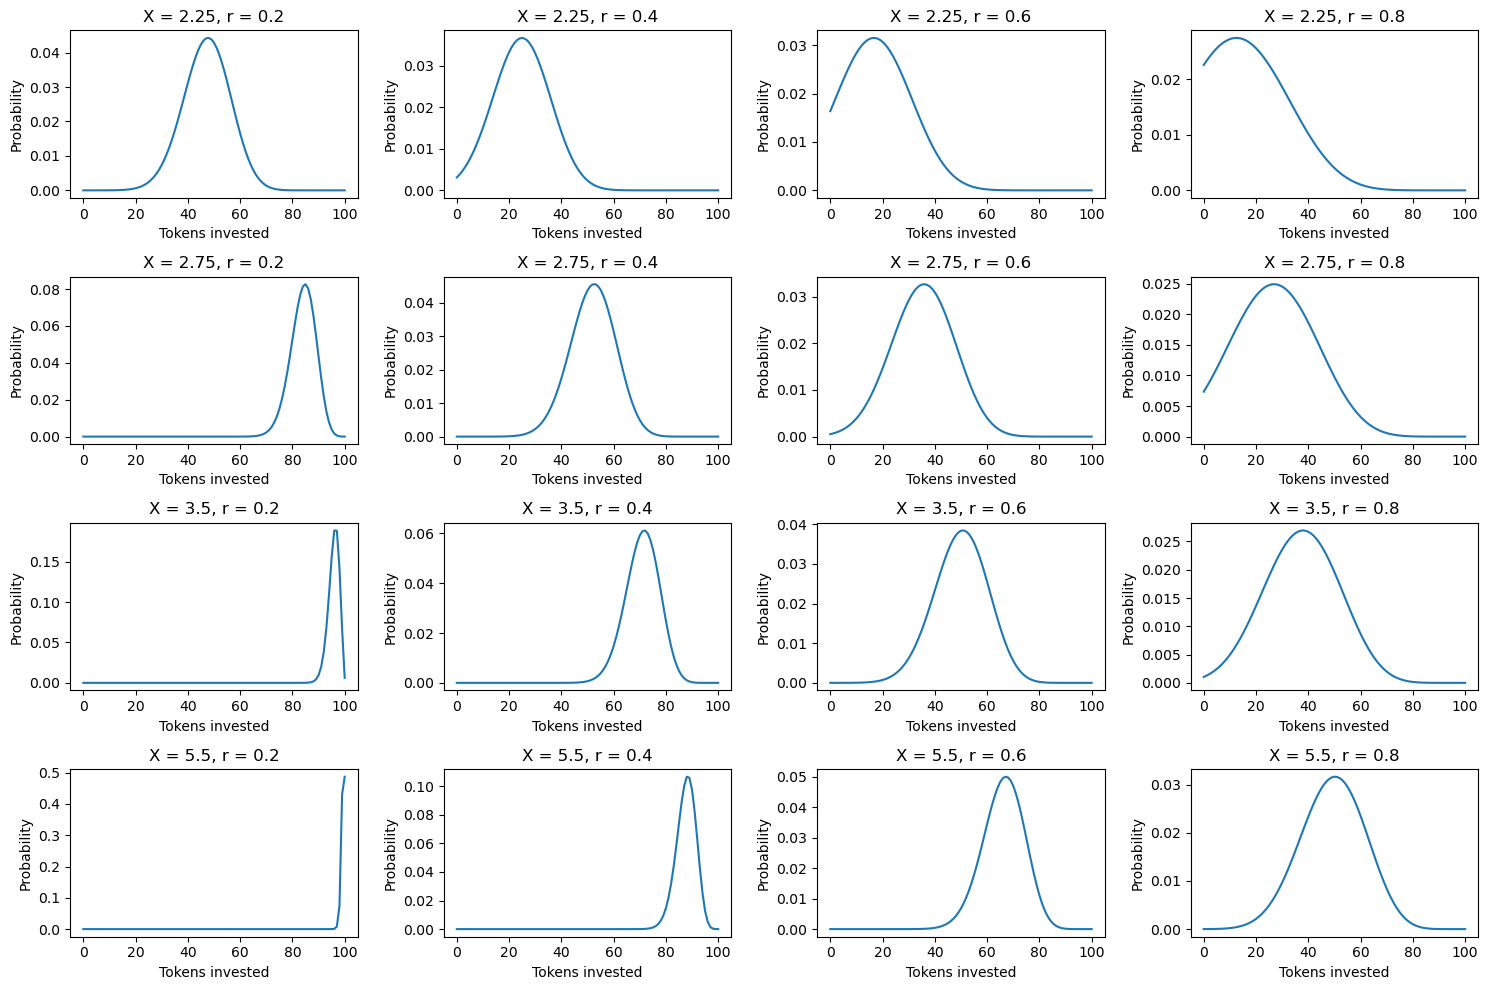

In [3]:
# Define the parameters
r_values = [0.2, 0.4, 0.6, 0.8]
X_values = [2.25, 2.75, 3.5, 5.5]
y_values = np.linspace(0, 100, 101)
_lambda = 10

# Create the initial DataFrame
df = pd.DataFrame([(X, y, r) 
                   for X in X_values 
                   for y in y_values 
                   for r in r_values], 
                  columns=['X', 'y', 'r'])

# Calculate EU
df['EU'] = 0.5 * (100 - df['y']) ** (1 - df['r']) / (1 - df['r']) + 0.5 * (100 + df['y'] * (df['X'] - 1)) ** (1 - df['r']) / (1 - df['r'])
#EU = 0.5*(100-ygrid).^ (1.0-r)/(1.0-r) + 0.5*(100+ygrid*(X[ii]-1)).^ (1.0-r)/(1.0-r);
# Calculate pr
df['pr'] = df.groupby(['X', 'r'])['EU'].transform(lambda x: np.exp(_lambda * (x - x.max())) / np.sum(np.exp(_lambda * (x - x.max()))))

# Create labels for X and r
df['X'] = 'X = ' + df['X'].astype(str)
df['r'] = 'r = ' + df['r'].astype(str)

# Create subplots
fig, axs = plt.subplots(len(r_values), len(X_values), figsize=(15, 10))

for ax, (group, group_df) in zip(axs.flat, df.groupby(['X', 'r'])):
    ax.plot(group_df['y'], group_df['pr'])
    ax.set_title(f'{group[0]}, {group[1]}')
    ax.set_xlabel('Tokens invested')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()

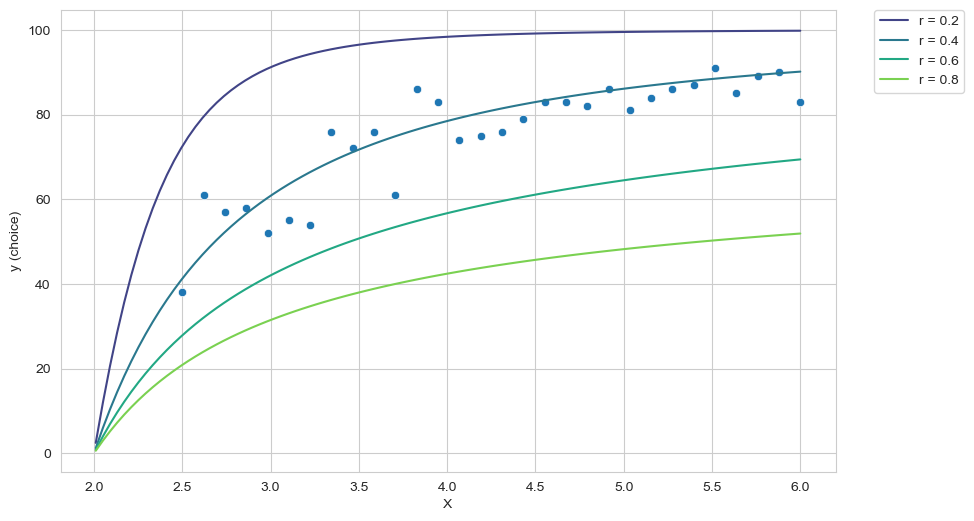

In [4]:
# Set seed
np.random.seed(42)

# Parameter values
r = 0.4
lambda_ = 10

# Create grid of y and X values
y_values = np.linspace(0, 100, num=101)
X_values = np.linspace(2.5, 6, num=30)
grid = list(product(y_values, X_values))

# Calculate expected utility and probability for each (y, X) pair
prob_dist = pd.DataFrame(grid, columns=['y', 'X'])
prob_dist['EU'] = 0.5 * (100 - prob_dist['y'])**(1 - r) / (1 - r) + 0.5 * (100 + prob_dist['y'] * (prob_dist['X'] - 1))**(1 - r) / (1 - r)
prob_dist['EU_max'] = prob_dist.groupby('X')['EU'].transform('max')
prob_dist['pr'] = np.exp(lambda_ * (prob_dist['EU'] - prob_dist['EU_max']))
prob_dist['pr'] /= prob_dist.groupby('X')['pr'].transform('sum')

# Generate data
data_points = []

for xx in prob_dist['X'].unique():
    d = prob_dist[prob_dist['X'] == xx]
    dataY = np.random.choice(d['y'], p=d['pr'])
    data_points.append({'y': dataY, 'X': xx})

data = pd.DataFrame(data_points)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Draw scatter plot
sns.scatterplot(data=data, x='X', y='y')

# Draw lines
sns.lineplot(data=dplt, x='X', y='y', hue='r', palette='viridis')

plt.xlabel('X')
plt.ylabel('y (choice)')

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 1.2 What do your data say about your theory?



In [5]:
# Create a dictionary of data that Stan can understand
stanData = {
    'y': np.round(data['y'] / 10).astype(int),
    'X': data['X'],
    'n': len(data['y']),
    'ygrid': np.arange(1, 11) * 10,
    'ny': 10,
    'prior_r': np.array([0.5, 0.25]),
    'prior_lambda': np.array([np.log(10), 0.5])
}

# Define file paths
model_path = "Code/Introduction/Introduction_InvestmentTask.stan"
compiled_model_file = "Outputs/Introduction/Introduction_InvestmentTask_Model.pkl"
fitted_model_file = "Outputs/Introduction/Introduction_InvestmentTask_Fit.pkl"

# Create output directory if it doesn't exist
output_dir = os.path.dirname(compiled_model_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load or compile the Stan model
if os.path.exists(compiled_model_file):
    with open(compiled_model_file, 'rb') as f:
        model = pickle.load(f)
else:
    model = pystan.StanModel(file=model_path)
    with open(compiled_model_file, 'wb') as f:
        pickle.dump(model, f)

# Fit the model or load the fitted model
if os.path.exists(fitted_model_file):
    with open(fitted_model_file, 'rb') as f:
        fit = pickle.load(f)
else:
    fit = model.sampling(data=stanData, seed=42)
    with open(fitted_model_file, 'wb') as f:
        pickle.dump(fit, f)

# Display a summary of the estimates
summary = fit.summary()
summary_df = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

print(summary_df)

             mean   se_mean        sd       2.5%        25%        50%  \
r        0.409158  0.000240  0.011075   0.386755   0.401889   0.409315   
lambda   6.871638  0.037932  1.704420   4.000503   5.652136   6.730169   
lp__   -32.391879  0.024332  1.004073 -35.220213 -32.746527 -32.090971   

              75%      97.5%        n_eff      Rhat  
r        0.416554   0.430168  2134.346665  0.999324  
lambda   7.896298  10.722702  2019.031234  1.000264  
lp__   -31.676595 -31.413915  1702.851513  1.002190  


## 1.3 What do your parameters say about other things?



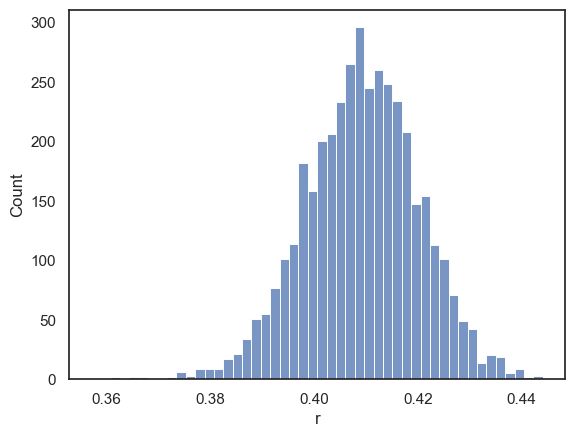

In [6]:

# Extract the samples for parameter 'r'
r_samples = fit.extract()['r']

# Create a DataFrame for plotting
df = pd.DataFrame({'r': r_samples})

# Set the seaborn white theme
sns.set_theme(style='white')

# Plot the histogram using seaborn
sns.histplot(df['r'], kde=False)

# Display the plot
plt.show()

In [7]:
import numpy as np

# Assuming 'fit' is the fitted Stan model object from pystan or cmdstanpy

# Extract the samples for parameter 'r'
r_samples = fit.extract(permuted=True)['r']

# Perform the calculation and logical comparison
calculation = (0.7 * 2.5**(1 - r_samples) / (1 - r_samples) +
               0.3 * 1**(1 - r_samples) / (1 - r_samples) -
               2**(1 - r_samples) / (1 - r_samples)) >= 0

# Calculate the mean of the boolean array resulting from the comparison
mean_value = np.mean(calculation)
print("{:.2f}".format(mean_value))

0.00


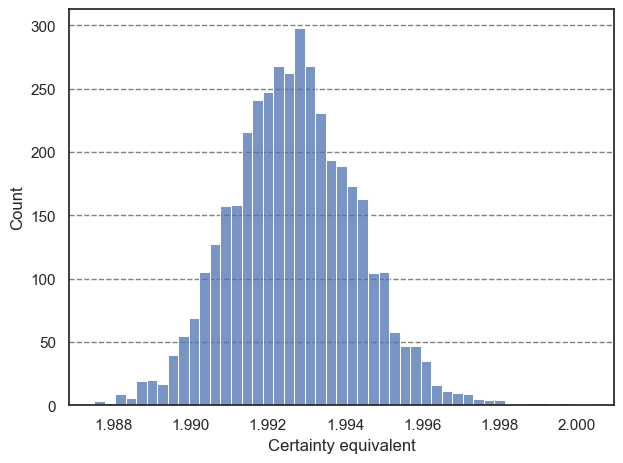

In [8]:


# Assuming 'r_samples' is an array containing your 'r' values from the Stan model
df = pd.DataFrame({'r': r_samples})

# Perform the calculation to create the 'C' column
df['C'] = (0.7 * 2.5**(1 - df['r']) + 0.3 * 1**(1 - df['r']))**(1 / (1 - df['r']))

# Set the seaborn white theme
sns.set_theme(style='white')

# Plot the histogram using seaborn
sns.histplot(df['C'], kde=False)

# Set the x-axis label
plt.xlabel("Certainty equivalent")

# Using matplotlib to apply a theme similar to theme_bw() in ggplot2
plt.grid(axis='y', linestyle='--', color='gray')
plt.tight_layout()

# Show the plot
plt.show()